In [5]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 584.2 kB/s eta 0:00:0000:0100:03


## 2.1. Segment & Crop Individual Cells

In [ ]:
import os
import cv2
import numpy as np
from scipy import ndimage as ndi
from skimage.morphology import local_maxima
from skimage.segmentation import watershed

# ————————————— Parameters ——————————————
# Bright‐field segmentation
MIN_AREA   = 20
MAX_AREA   = 5000
MIN_SOLID  = 0.3

# Blob & circle detection
BLOB_MIN_AREA      = 5
BLOB_MAX_AREA      = 4000
HOUGH_DP           = 1.2
HOUGH_MIN_DIST     = 10
HOUGH_PARAM1       = 60
HOUGH_PARAM2       = 15
HOUGH_MIN_RADIUS   = 6
HOUGH_MAX_RADIUS   = 45

# NMS (IoU threshold)
NMS_IOU_THRESH     = 0.3

# Fluorescence classification

# 1) Load images & build BF mask ———————————
bf8 = cv2.imread("../data/raw/bright_field.png", cv2.IMREAD_GRAYSCALE)
fl8 = cv2.imread("../data/raw/fluorescent_labeled.png", cv2.IMREAD_GRAYSCALE)

bg = cv2.morphologyEx(bf8, cv2.MORPH_OPEN, K50)
tophat = cv2.subtract(bf8, bg)
tophat = cv2.normalize(tophat, None, 0,255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
_, bf_mask = cv2.threshold(
    tophat, 0, 255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

# 4) Black‐hat for dark spheres
blackhat = cv2.morphologyEx(bf8, cv2.MORPH_BLACKHAT, K50)
blackhat = cv2.normalize(blackhat, None, 0,255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
_, dark_mask = cv2.threshold(
    blackhat, 0, 255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

fl_thresh = np.percentile(fl8, 90)
_, fl_mask = cv2.threshold(fl8, fl_thresh, 255, cv2.THRESH_BINARY)

mask_seg = cv2.bitwise_or(bf_mask, dark_mask)
mask_seg = cv2.bitwise_or(mask_seg, fl_mask)

lf = cv2.adaptiveThreshold(
    cv2.GaussianBlur(tophat, (5,5), 0),
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    51, -5
)
mask_seg = cv2.bitwise_or(mask_seg, lf)

# Clean segmentation mask
K3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
mask_seg = cv2.morphologyEx(mask_seg, cv2.MORPH_OPEN,  K3, iterations=1)
mask_seg = cv2.morphologyEx(mask_seg, cv2.MORPH_CLOSE, K3, iterations=1)

# 2) Detect blobs (SimpleBlob) + Hough circles
# Prepare pre-processed BF for detection
clahe     = cv2.createCLAHE(2.0,(8,8))
bf_eq     = clahe.apply(bf8)
bf_smooth = cv2.medianBlur(bf_eq, 3)
K5        = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
bf_closed = cv2.morphologyEx(bf_smooth, cv2.MORPH_CLOSE, K5)

# SimpleBlobDetector setup
params = cv2.SimpleBlobDetector_Params()
params.filterByArea        = True
params.minArea             = BLOB_MIN_AREA
params.maxArea             = BLOB_MAX_AREA
params.filterByCircularity = False
params.filterByInertia     = False
params.filterByConvexity   = False
detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(bf_closed)

# HoughCircles
circles = cv2.HoughCircles(
    bf_closed,
    cv2.HOUGH_GRADIENT, 
    dp=HOUGH_DP, 
    minDist=HOUGH_MIN_DIST,
    param1=HOUGH_PARAM1,
    param2=HOUGH_PARAM2,
    minRadius=HOUGH_MIN_RADIUS,
    maxRadius=HOUGH_MAX_RADIUS
)
hc = [] if circles is None else circles[0]

# Combine detections
dets = []
for kp in keypoints:
    x,y = kp.pt; r = kp.size/2
    dets.append((int(x),int(y),int(r)))
for x,y,r in hc:
    dets.append((int(x),int(y),int(r)))

# 3) Morphological opening to knock down tiny noise
K3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
mask_seg_clean = cv2.morphologyEx(mask_seg, cv2.MORPH_OPEN, K3, iterations=1)

# Distance transform & threshold to get “sure foreground” markers
distance = ndi.distance_transform_edt(mask_seg_clean)

# Find all local maxima as a boolean map
local_maxi = local_maxima(distance) & (mask_seg_clean > 0)

# Label those maxima to use as watershed seeds
markers, _ = ndi.label(local_maxi)

# Perform watershed on the NEGATIVE distance map
labels_ws = watershed(-distance, markers, mask=mask_seg_clean)

# Extract one circle per watershed region
final_dets = []
for lab in np.unique(labels_ws):
    if lab == 0:
        continue
    mask_i = (labels_ws == lab).astype('uint8') * 255
    cnts, _ = cv2.findContours(mask_i, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        continue
    cnt = cnts[0]
    (cx, cy), r = cv2.minEnclosingCircle(cnt)
    final_dets.append((int(cx), int(cy), int(r)))

print(f"Split into {len(final_dets)} circles with peak‐local‐max + watershed")

# 4) Classify each final detection by raw‐Otsu “any‐pixel”
# a) Build raw Otsu mask 
_, fl_otsu = cv2.threshold(fl8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
fl_mask   = (fl_otsu > 0)

# b) Crop, classify, save & visualize
H, W = bf8.shape
vis  = cv2.cvtColor(bf8, cv2.COLOR_GRAY2BGR)
crops, labels_ctc = [], []

for idx, (x, y, r) in enumerate(final_dets, start=1):
    # Round & clamp to image bounds
    x0 = max(0, int(x - r))
    y0 = max(0, int(y - r))
    x1 = min(W,   int(x + r))
    y1 = min(H,   int(y + r))

    # Skip any empty or degenerate boxes
    if x1 <= x0 or y1 <= y0:
        continue
    # Skip circles that are too small to trust
    if r < 2:
        continue

    # Classify via raw‐Otsu mask as before
    roi_mask = fl_mask[y0:y1, x0:x1]
    is_ctc   = roi_mask.any()
    color    = (0,255,0) if is_ctc else (0,0,255)

    # Draw circle and center
    cv2.circle(vis, (int(x),int(y)), int(r), color, 1)
    cv2.circle(vis, (int(x),int(y)), 2, color, -1)

    # Resize
    patch = cv2.resize(
        bf8[y0:y1, x0:x1],
        (64,64),
        interpolation=cv2.INTER_AREA
    )
    out_dir = "../data/raw/ctc" if is_ctc else "../data/raw/non_ctc"
    os.makedirs(out_dir, exist_ok=True)
    cv2.imwrite(f"{out_dir}/cell_{idx}.png", patch)

    crops.append(patch)
    labels_ctc.append(int(is_ctc))

# 5) Write debug & summary
cv2.imwrite("debug_circles_clamped.png", vis)
print(f"Extracted {len(crops)} crops, {sum(labels_ctc)} CTCs.")


Split into 392 circles with peak‐local‐max + watershed
Extracted 315 crops, 63 CTCs.


## 2.2. Resize, Normalize & Augment

Train: (220, 64, 64, 1) Val: (47, 64, 64, 1) Test: (48, 64, 64, 1)


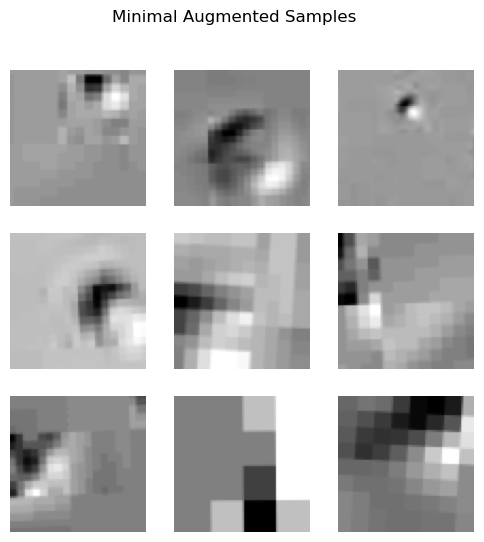

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Load & preprocess into arrays
def load_images(folder, label):
    X, y = [], []
    for fname in sorted(os.listdir(folder)):
        path = os.path.join(folder, fname)
        img = Image.open(path).convert("L")        # grayscale
        img = img.resize((64,64), Image.Resampling.LANCZOS)
        arr = np.array(img, dtype=np.float32)/255.0
        X.append(arr)
        y.append(label)
    return X, y

X_ctc, y_ctc     = load_images("../data/raw/ctc",     1)
X_nonctc, y_nonctc = load_images("../data/raw/non_ctc", 0)

X = np.stack(X_ctc + X_nonctc)[..., np.newaxis]  # shape (N,64,64,1)
y = np.array(y_ctc + y_nonctc)

# Save for later
np.save("../data/processed/X.npy", X)
np.save("../data/processed/y.npy", y)

# 2. Split into train/val/test
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y,
    test_size=0.3, stratify=y, random_state=42)
X_val,   X_test, y_val,   y_test = train_test_split(X_tmp, y_tmp,
    test_size=0.5, stratify=y_tmp, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# 3. Set up Keras ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.02,
    height_shift_range=0.02,
    zoom_range=0.05,
    fill_mode="nearest"
)

# Create a generator just for visualization
vis_gen   = train_datagen.flow(X_train[:9], y_train[:9], batch_size=9, shuffle=False)
aug_imgs, _ = next(vis_gen)

# 4. Visualize a batch of augmented examples
fig, axes = plt.subplots(3,3, figsize=(6,6))
for ax, im in zip(axes.flat, aug_imgs):
    ax.imshow(im.squeeze(), cmap="gray")
    ax.axis("off")
plt.suptitle("Minimal Augmented Samples")
plt.show()


## Generate Images 

In [ ]:
import cv2
import numpy as np
from skimage.filters import threshold_otsu
from skimage.morphology import white_tophat, black_tophat, disk
from skimage.segmentation import watershed  
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

# 1. Load BF + FL images
bf = cv2.imread('../data/raw/bright_field.png', cv2.IMREAD_GRAYSCALE)
fl = cv2.imread('../data/raw/fluorescent_labeled.png', cv2.IMREAD_GRAYSCALE)

# 2. Segmentation (white top-hat + Otsu)
tophat = white_tophat(bf, disk(25))
th = threshold_otsu(tophat)
mask = (tophat > th).astype(np.uint8) * 255
plt.imsave('seg.png', mask, cmap='gray')

# 3. Detection (SimpleBlobDetector)
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea, params.maxArea = 5, 4000
det = cv2.SimpleBlobDetector_create(params)
kps = det.detect(bf)
det_vis = cv2.drawKeypoints(bf, kps, None, (255,0,0),
                            cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imsave('det.png', det_vis, cmap='gray')

# 4. Clustering (marker-based watershed)
distance = ndi.distance_transform_edt(mask)

# find the peak coordinates
coords = peak_local_max(
    distance,
    footprint=np.ones((3,3)),
    labels=mask
)

# build a marker image from those coords
markers = np.zeros(distance.shape, dtype=int)
for idx, (r, c) in enumerate(coords, start=1):
    markers[r, c] = idx

# run watershed
labels = watershed(-distance, markers, mask=mask)
clu_vis = cv2.cvtColor(bf, cv2.COLOR_GRAY2BGR)
for lbl in np.unique(labels):
    if lbl == 0: continue
    ys, xs = np.where(labels == lbl)
    cy, cx = int(ys.mean()), int(xs.mean())
    cv2.circle(clu_vis, (cx, cy), 12, (0,255,0), 1)
plt.imsave('clu.png', clu_vis)

# 5. Cropping one detection
x, y = map(int, kps[0].pt)
patch = bf[y-32:y+32, x-32:x+32]
plt.imsave('crop.png', patch, cmap='gray')

# 6.Patch for ML visualization
plt.imsave('ml.png', patch, cmap='gray')


In [ ]:
import cv2
import numpy as np

# Load the three full‐frame images
bf_overlay = cv2.imread('debug_circles_clamped.png')   
seg_mask   = cv2.imread('debug_raw_mask.png',   0)      
clu_waters = cv2.imread('debug_fl_mask.png')         

# Define crop window
x0, y0, w, h = 200, 150, 128, 128 

# 1. Segmentation
seg_thumb = seg_mask[y0:y0+h, x0:x0+w]
cv2.imwrite('thumb_segmentation.png', seg_thumb)

# 2. Detection overlay
det_thumb = bf_overlay[y0:y0+h, x0:x0+w]
cv2.imwrite('thumb_detection.png', det_thumb)

# 3. Clustering
clu_thumb = clu_waters[y0:y0+h, x0:x0+w]
cv2.imwrite('thumb_clustering.png', clu_thumb)

# 4. Cropping (pick the first detected circle)
x_c, y_c = x0 + w//2, y0 + h//2
half = 32
bf = cv2.imread('../data/raw/bright_field.png', 0)
patch = bf[y_c-half:y_c+half, x_c-half:x_c+half]
cv2.imwrite('thumb_cropping.png', patch)

# 5. ML Input (normalized patch)
patch_norm = patch.astype(np.float32)/255.0
scaled = (patch_norm*255).astype(np.uint8) 
cv2.imwrite('thumb_ml_input.png', scaled)


True

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Load data arrays
X = np.load('../data/processed/X.npy')     
y = np.load('../data/processed/y.npy')  

# 2. Basic counts
N_total = X.shape[0]
counts = {int(cls): int((y == cls).sum()) for cls in np.unique(y)}

# 3. Stratified splits: 70/15/15
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.17647,
    stratify=y_temp, random_state=42)

# 4. Build a table DataFrame
import pandas as pd
data = [
    ['Total patches',        N_total,               ''],
    ['–   CTCs',             counts[1],             ''],
    ['–   WBCs',             counts[0],             ''],
    ['Training (70\%)',      X_train.shape[0],      'stratified'],
    ['Validation (15\%)',    X_val.shape[0],        ''],
    ['Test (15\%)',          X_test.shape[0],       ''],
]
df = pd.DataFrame(data, columns=['Stage','Count','Notes'])
print(df.to_latex(index=False,
                  caption='Data volumes and splits',
                  label='tab:data_volume'))


\begin{table}
\caption{Data volumes and splits}
\label{tab:data_volume}
\begin{tabular}{lrl}
\toprule
Stage & Count & Notes \\
\midrule
Total patches & 315 &  \\
–   CTCs & 63 &  \\
–   WBCs & 252 &  \\
Training (70\%) & 219 & stratified \\
Validation (15\%) & 48 &  \\
Test (15\%) & 48 &  \\
\bottomrule
\end{tabular}
\end{table}

